In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

X=pd.read_csv('titanic/train.csv',index_col='PassengerId')
X_test_full = pd.read_csv('titanic/test.csv',index_col='PassengerId')

X.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
X_test_full.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
#Remove rows without Survive data
X.dropna(axis=0,subset=['Survived'],inplace=True)
y=X.Survived
X.drop(['Survived'],axis=1,inplace=True)

#Remove Name from data
X.drop(['Name'],axis=1,inplace=True)
X_test_full.drop(['Name'],axis=1,inplace=True)

X_train_full,X_valid_full,y_train,y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2, random_state=0)



In [14]:
#Select categorical cols with low cardinality
categorical_cols = [cname for cname in X_train_full.columns if
                   X_train_full[cname].nunique()<10 and
                   X_train_full[cname].dtype == 'object']

#Select numerical cols
numerical_cols = [cname for cname in X_train_full.columns if
                 X_train_full[cname].dtype in ['int64','float64']]

my_cols=categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [15]:
X_train.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
141,female,C,3,NaN,0,2,15.2458
440,male,S,2,31.0,0,0,10.5000
818,male,C,2,31.0,1,1,37.0042
379,male,C,3,20.0,0,0,4.0125
492,male,S,3,21.0,0,0,7.2500


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('OneHote',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer,numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model = XGBRegressor(n_estimators=300, learning_rate=0.05)

clf=Pipeline(steps=[('preprocessor',preprocessor),
                   ('model',model)])

clf.fit(X_train,y_train)

predictions = clf.predict(X_valid)
mae = mean_absolute_error(y_valid,predictions)
print(mae)


0.220417221498223


In [26]:
from sklearn.model_selection import cross_val_score

def score_model(n_estimators,learning_rate):
    score_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                    ('model',XGBRegressor(n_estimators=n_estimators,learning_rate=learning_rate))])
    scores = -1 * cross_val_score(score_pipeline,X_train,y_train,
                                 cv=5,
                                 scoring='neg_mean_absolute_error')
    return scores.mean()
    


NameError: name 'plot' is not defined

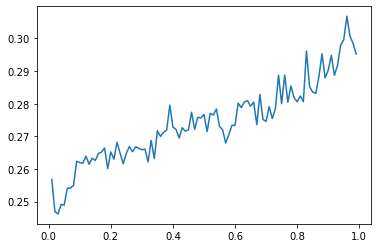

In [35]:
learning_rate_results={}
for j in range(1,100):
    learning_rate_results[j*0.01]=score_model(300,j*0.01)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(learning_rate_results.keys()),list(learning_rate_results.values()))
plt.show()

In [36]:
results_ = {}
for i in range(1,9):
    for j in range(1,20):
        results[(i*50,j*0.01)]=score_model(i*50,j*0.01)
print(results)

{(50, 0.01): 0.40319255768524814, (50, 0.02): 0.34162320401015034, (50, 0.03): 0.30203346847331336, (50, 0.04): 0.278065227100817, (50, 0.05): 0.2639800308042003, (50, 0.06): 0.2558253136430716, (50, 0.07): 0.2523717943029687, (50, 0.08): 0.24958781639566613, (50, 0.09): 0.24929763788039444, (50, 0.1): 0.2479252199935617, (50, 0.11): 0.24688342685102066, (50, 0.12): 0.24760963028873068, (50, 0.13): 0.247228062558524, (50, 0.14): 0.24501707083830443, (50, 0.15): 0.2465119623288396, (50, 0.16): 0.24831931625876208, (50, 0.17): 0.2463141203648725, (50, 0.18): 0.25049665879935545, (50, 0.19): 0.2461675275857961, (50, 0.2): 0.24836180221708046, (50, 0.21): 0.24853130679558877, (50, 0.22): 0.25366936752529173, (50, 0.23): 0.2510267533907148, (50, 0.24): 0.24736134495410406, (50, 0.25): 0.2514277554008628, (50, 0.26): 0.25371859037035455, (50, 0.27): 0.2529022120894041, (50, 0.28): 0.25676284695181206, (50, 0.29): 0.257873170930365, (50, 0.3): 0.2577402667548167, (50, 0.31): 0.257908807007019

In [37]:
import operator
sorted_results=sorted(results.items(),key=operator.itemgetter(1))
print(sorted_results)

[((250, 0.03), 0.24490499254794917), ((50, 0.14), 0.24501707083830443), ((150, 0.06), 0.24560074439004623), ((150, 0.05), 0.24562628018695193), ((200, 0.03), 0.24592123763597415), ((100, 0.07), 0.24608950564206838), ((100, 0.08), 0.24616620461335853), ((50, 0.19), 0.2461675275857961), ((300, 0.03), 0.24621900702760358), ((200, 0.04), 0.2462420596132886), ((400, 0.02), 0.24628259669697647), ((50, 0.17), 0.2463141203648725), ((150, 0.07), 0.24647825756977548), ((50, 0.15), 0.2465119623288396), ((200, 0.05), 0.24666818653839767), ((50, 0.11), 0.24688342685102066), ((300, 0.02), 0.2468971940125666), ((350, 0.02), 0.24690111406616397), ((100, 0.06), 0.2469153281319239), ((150, 0.04), 0.2470007703722398), ((350, 0.03), 0.24709599314593778), ((50, 0.13), 0.247228062558524), ((100, 0.11), 0.24725036442596826), ((50, 0.24), 0.24736134495410406), ((50, 0.12), 0.24760963028873068), ((250, 0.05), 0.24763422741639157), ((200, 0.06), 0.2477512698123388), ((250, 0.04), 0.2477663399209697), ((250, 0.0

In [41]:
model_2=XGBRegressor(n_estimators=250,learning_rate=0.03)
model_2_pipeline=Pipeline(steps=[('preprocessor',preprocessor),
                                ('model',model_2)])
model_2_pipeline.fit(X_train,y_train)
model_2_preds=model_2_pipeline.predict(X_valid)
mae=mean_absolute_error(y_valid,model_2_preds)
print(mae)

0.22051078730455323


In [48]:
X_test = X_test_full[my_cols].copy()
X_test.columns

Index(['Sex', 'Embarked', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [65]:
final_preds=model_2_pipeline.predict(X_test)
i=0
for prediction in final_preds:
    prediction = int(round(prediction))
    final_preds[i]=prediction
    i+=1

print(final_preds)

output = pd.DataFrame({'PassengerId':X_test.index,
                      'Survived':final_preds})
output.to_csv('titanic_model_2.csv',index=False)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.